In [1]:
import geopandas as geopd
import pandas as pd
from shapely.geometry import box

import rasterio
from rasterio.plot import show
from rasterio.windows import from_bounds
from rasterio.features import rasterize

import watershed_utils as wu

import numpy as np

try:
    from whitebox.WBT.whitebox_tools import WhiteboxTools
except:
    from whitebox.whitebox_tools import WhiteboxTools

import os

from time import sleep

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"]  = 400
plt.style.use('dark_background')

In [2]:
# Options
# Buffer distance to ensure that rivers don't get split by edge effects
buffer_d = 10_000

# Root directory for DEM data
root = "/path/to/filename"

# Path to the DEM VRT file
dem_vrt_path = os.path.join(root, "filename.vrt")

# Paths to catchments and network data
catchments_path = "/path/to/filename.gpkg"
network_path = "/path/to/filename.gpkg" 
raise_vector_path = "/path/to/filename.gpkg"

# To limit memory usage, each catchment is processed separately

In [10]:
# Read catchments data
catchments = geopd.read_file(catchments_path, layer='v1')

# Create bounding boxes for catchments
bboxs = catchments.envelope

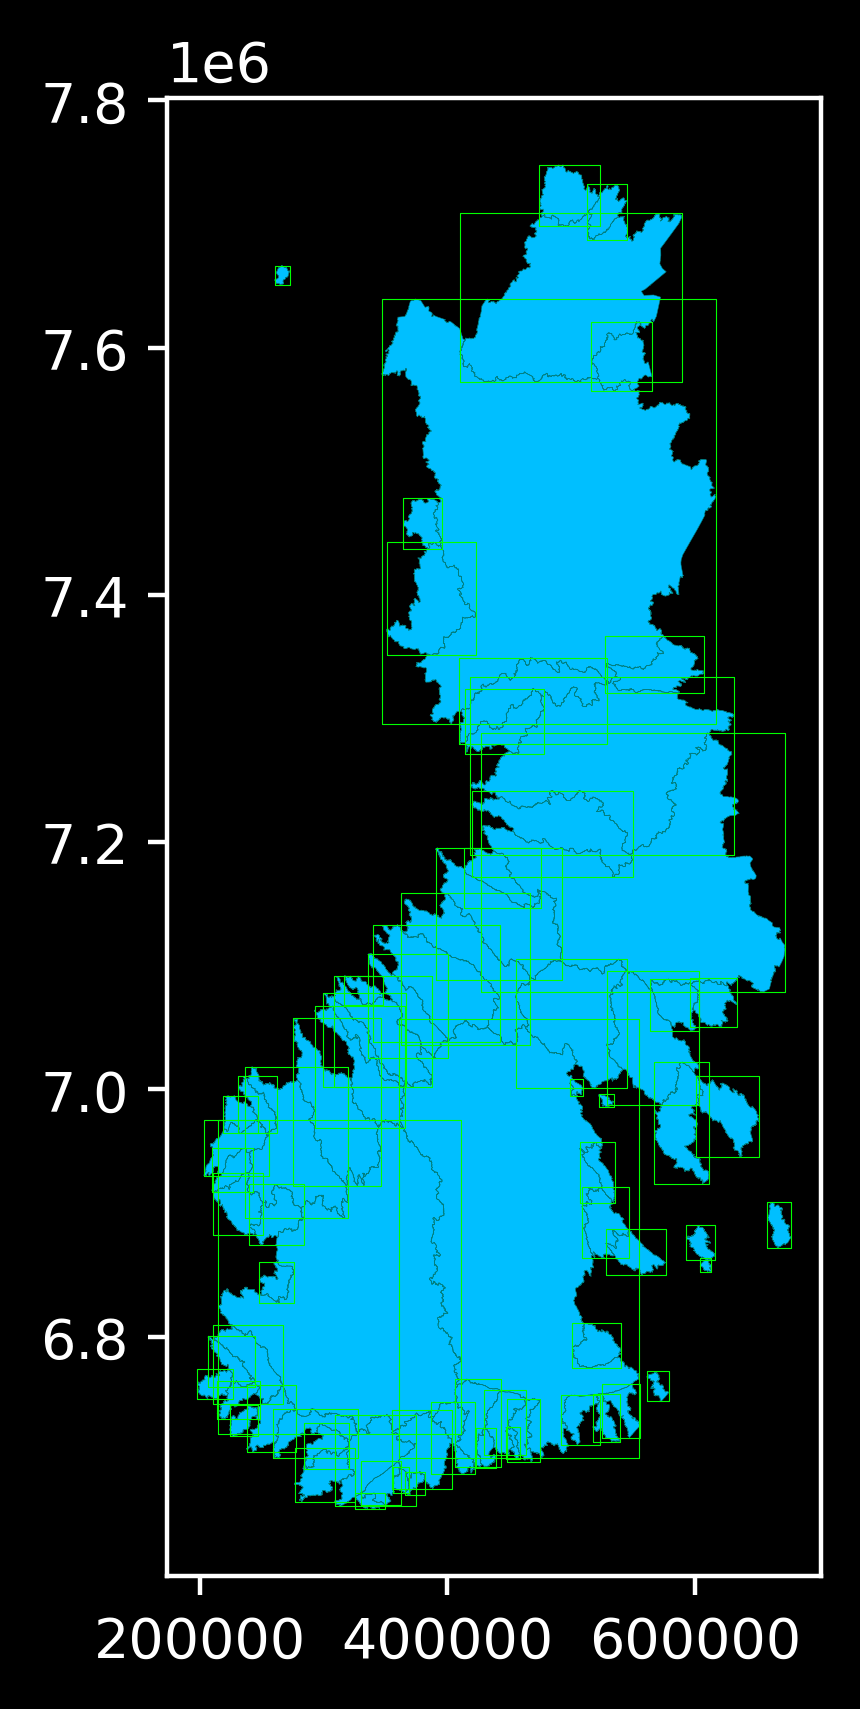

In [11]:
# Plot catchments and their bounding boxes
ax = catchments.boundary.plot(color='teal', linewidth=0.1)
ax = bboxs.boundary.plot(ax=ax, color='lime', linewidth=0.2)
ax = catchments.plot(ax=ax, color='deepskyblue')

# To ensure working edges, the DEM is read from a vrt with an area that is buffered by a few pixels width. 
- The results are cropped to the original catchment
- catchment is written to a new directory
- a text file of paths is created
### The order of operations is:
- burn (dig) the river network
- raise the boundaries of watershed to prevent watershed bleeding
- dig the intersection of the boundaries and river network to be in a pit
- breach depressions
- d8 pointer
- d8 flow accumulation
- value clipping the flow accumulation

In [21]:
# Define the order of operations for DEM preprocessing
print("burn")
burn_paths = wu.burn_river_graph(
    catchments, network_path, root,
    dem_vrt_path, buffer_d=20)

burn


  0%|          | 0/74 [00:00<?, ?it/s]

In [ ]:
burn_paths = os.path.join(root, "burn_10m.txt")

print("raise")
"""
raise_paths = wu.paralell_process_catchments(
    "raise", catchments, root,
    burn_paths, buffer_d=20)
"""
# Adding extra walls to places that proved problematic for the breach algorithm
raise_paths = wu.paralell_process_catchments(
    "raise", catchments, root,
    burn_paths, buffer_d=20, raise_path=raise_vector_path)

print("dig_intersection")
dig_intersection_paths = wu.paralell_process_catchments(
    "dig_intersection", catchments, root, raise_paths,
    buffer_d=20, network_path=network_path)
dig_intersection_paths = os.path.join(root, "dig_intersection_10m.txt")

In [7]:
print("breach")
# Requires 64 GB to run parallel because just Kemijoki uses 18 GB
breach_paths = wu.paralell_process_catchments(
    "breach", catchments, root,
    dig_intersection_paths, buffer_d=20, n_cpu=6)

print("d8_pointer")
d8_paths = wu.paralell_process_catchments(
    "d8_pointer", catchments, root,
    breach_paths, buffer_d=20)

print("d8_flow_accumulation")
flow_acc_paths = wu.paralell_process_catchments(
    "d8_flow_accumulation", catchments, root,
    d8_paths, buffer_d=20)

print("stream_thresholding")
stream_paths = wu.paralell_process_catchments(
    "stream_thresholding", catchments, root,
    flow_acc_paths, buffer_d=20)

breach


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

d8_pointer


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

d8_flow_accumulation


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

stream_thresholding


DONE:   0%|          | 0/74 [00:00<?, ?it/s]

In [5]:
def process_individual_catchments(operation_name, catchments, root, catchment_id, buffer_d,
                                  source_txt_path=None, network_path=None, raise_path=None,
                                  verbose=False, src_vrt_path=None):
    """ Convenience wrapper for processing individual catchment tiffs
    Parameters:
    operation_name (str): The name of the operation to perform.
    catchments (GeoDataFrame): The GeoDataFrame containing catchment geometries.
    root (str): The root directory for DEM data.
    catchment_id (int): The ID of the catchment to process.
    buffer_d (int): The buffer distance to apply.
    source_txt_path (str, optional): Path to the source text file.
    network_path (str, optional): Path to the network data.
    raise_path (str, optional): Path to the raise vector data.
    verbose (bool, optional): Whether to enable verbose mode.
    src_vrt_path (str, optional): Path to the source VRT file.

    Returns:
    str: The path to the text file containing the processed file paths.
    """
    if operation_name != "burn":
        sources = pd.read_csv(source_txt_path, header=None, names=["path"])

    dst_dir = os.path.join(root, operation_name) 
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)
    
    # Text file that contains path of all the processed files
    dst_txt_path = os.path.join(root, f"{operation_name}_10m.txt")
    
    wbt = WhiteboxTools()
    wbt.set_verbose_mode(verbose)
    
    dst_file_paths = []
    k = 0
    with tqdm(catchments.iterrows(), total=len(catchments)) as pbar:
        for j, catchment in pbar:
            if j != catchment_id:
                k +=1
                continue
            pbar.set_description(f" Doing {operation_name} for catchment {j}")
            
            # Changing the catchment from series to dataframe 
            catchment = geopd.GeoDataFrame(
                    dict(zip(list(catchment.index), list(catchment.values))),
                    crs=catchments.crs, geometry='geometry', index=[0])
    
            catchment_minx = catchment.bounds.at[0, 'minx']
            catchment_miny = catchment.bounds.at[0, 'miny']
            catchment_maxx = catchment.bounds.at[0, 'maxx']
            catchment_maxy = catchment.bounds.at[0, 'maxy']
            
            # Buffering so that edge effects can be mitigated
            buffer = catchment.buffer(buffer_d, join_style='mitre')
            bounds = buffer.bounds
    
            minx = bounds.at[0, 'minx']
            miny = bounds.at[0, 'miny']
            maxx = bounds.at[0, 'maxx']
            maxy = bounds.at[0, 'maxy']
    
            # Fetching the filename
            if operation_name != "burn":
                src_path = sources.at[k, 'path']

            dst_path = os.path.join(dst_dir, f"{operation_name}_{j}.tif")
            dst_file_paths.append(dst_path)

            if operation_name == "burn":
                network = geopd.read_file(network_path, bbox=(minx, miny, maxx, maxy))
                """ reading only the portion of the raster that falls on the buffered area.
                The catchment and dataset need to be in the same projection.
                If the buffer falls outside of the bounds of vrt, the portion is filled with nodata
                """
                with rasterio.open(src_vrt_path) as src:
                    profile = src.profile
                    values = src.read(
                        1, window=from_bounds(minx, miny, maxx, maxy, src.transform),
                        boundless=True, fill_value=profile['nodata'])

                
                # Updating the profile and recalculating the transform to match the values
                profile['transform'] = rasterio.transform.from_bounds(minx, miny, maxx, maxy, values.shape[1], values.shape[0])
                profile['width'] = values.shape[1]
                profile['height'] = values.shape[0]
                profile['driver'] = 'GTiff'
    
                # Rasterizing the network.
                rasterized = rasterize(
                    network['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'])
                
                # burning the river channels 1 meter deep
                values = np.where(rasterized==1, values - 1, values)
                
                # Saving the opened raster as a temporary file
                with rasterio.open(dst_path, 'w', **profile) as dst:
                    dst.write(values, 1)
            
            elif operation_name == "raise":
                # Raise is either performed with the boundary of the watershed or a custom file, if it is provided
                if raise_path != None:
                    boundary = geopd.read_file(raise_path, bbox=(minx, miny, maxx, maxy))
                        
                else: # default, use the watershed boundary
                    boundary = catchment.boundary.explode().reset_index()
                    boundary['length'] = boundary.length
                    boundary = boundary.loc[boundary['length'] > 160]
                    boundary = boundary.rename({0:'geometry'}, axis=1)

                # There are no changes for this watershed, we can just copy the existing file
                if len(boundary) == 0:
                    # if there are no changes and the paths stay the same, there is no need to copy
                    if src_path != dst_path:
                        copyfile(src_path, dst_path)
                
                else:
                    with rasterio.open(src_path) as src:
                        values = src.read(1)
                        profile = src.profile
                        mask = src.read_masks(1)
    
                    # Rasterizing the catchment boundary.
                    rasterized = rasterize(
                        boundary['geometry'], (profile['height'], profile['width']),
                        dtype=profile['dtype'], transform=profile['transform'])
                
                    # raising the catchment boundaries as walls
                    values = np.where(rasterized==1, values + 100, values)
    
                    with rasterio.open(dst_path, 'w', **profile) as dst:
                            dst.write(values, 1)
                        
            elif operation_name == "dig_intersection":
                """ Walls that are raised around the catchments need to be breached on the pour point of the catchment
                """
                # This operation requires additional keyword argument to function
                assert network_path is not None, "operation dig_intersection requires the keyword argument network_path"
                boundary = catchment.boundary.explode().reset_index()
                boundary['length'] = boundary.length
                boundary = boundary.loc[boundary['length'] > 160]
                boundary = boundary.rename({0:'geometry'}, axis=1)
                boundary = boundary.set_geometry('geometry', crs=catchment.crs)
                
                network = geopd.read_file(network_path, bbox=(minx, miny, maxx, maxy))
                intersection = geopd.overlay(boundary, network, keep_geom_type=False)

                if len(intersection) == 0:
                    print(f"{operation_name} failed for catchment {j} because there were no intersections")
                    continue
                    
                intersection['geometry'] = intersection.buffer(10, cap_style='square')
                
                with rasterio.open(src_path) as src:
                    values = src.read(1)
                    profile = src.profile
                    mask = src.read_masks(1)

                rasterized = rasterize(
                    intersection['geometry'], (profile['height'], profile['width']),
                    dtype=profile['dtype'], transform=profile['transform'])
                
                values = np.where(rasterized==1, values - 110, values)

                with rasterio.open(dst_path, 'w', **profile) as dst:
                        dst.write(values, 1)
                
            elif operation_name == "breach":
                status = wbt.breach_depressions_least_cost(src_path, dst_path, dist=10, max_cost=50)

                
            elif operation_name == "d8_pointer":
                status = wbt.d8_pointer(src_path, dst_path)

            elif operation_name == "d8_flow_accumulation":
                status = wbt.d8_flow_accumulation(src_path, dst_path, pntr=True)

            elif operation_name == "stream_thresholding":
                with rasterio.open(src_path) as src:
                    values = src.read(1)
                    profile = src.profile
                    mask = src.read_masks(1)
                
                values = np.where(values > 40_000, 1, 0).astype('uint8')
                profile['dtype'] = 'uint8'
                # update nodata to 255
                values = np.where(mask == 0, 255, values)
                profile['nodata'] = 255
                
                with rasterio.open(dst_path, 'w', **profile) as dst:
                        dst.write(values, 1)

            else:
                raise Exception(f"Unregocnized operation name {operation_name}")
    
            k +=1
    
    return dst_txt_path